Nolan Roth <br>
PHYS 434 AC

# Lab #7

In [8]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
from scipy.stats import norm
from astropy.table import QTable, Table, Column
from astropy import units as u
import numpy as np
import pickle
import h5py
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 10)

In [9]:
infile = open ('higgs_250_500.pkl','rb')
higgs_data = pickle.load(infile)
infile = open ('qcd_250_500.pkl', 'rb')
qcd_data = pickle.load(infile)

In [10]:
higgs_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

## Problem 1

Making a stacked histogram for Higgs mass data versus QCD mass data, normalized to expected yield, without any event selection:

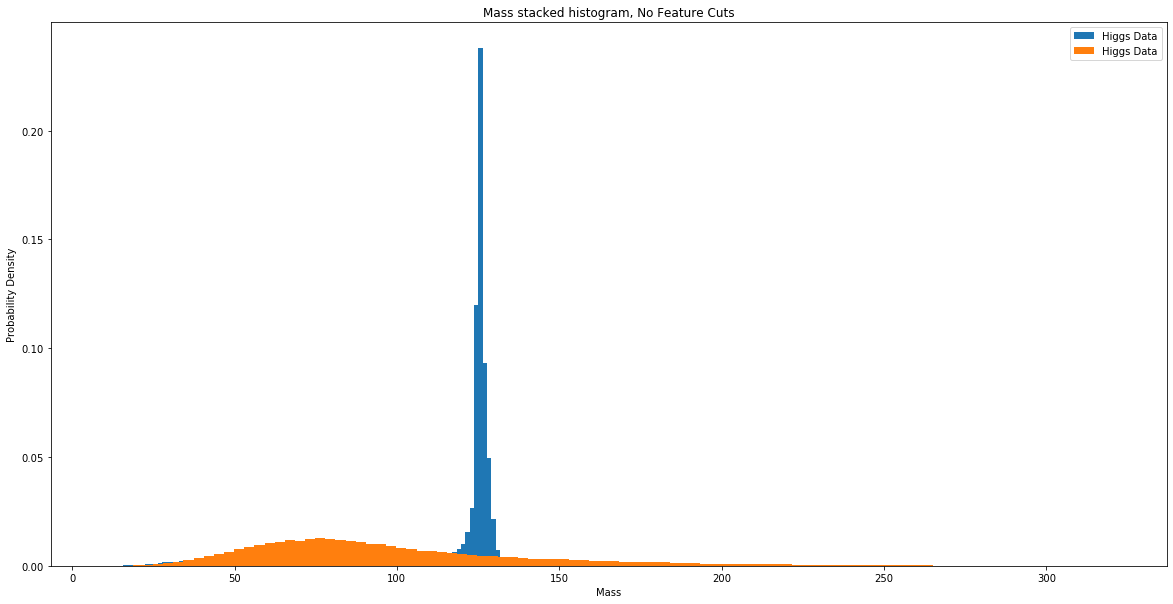

In [4]:
plt.hist(higgs_data['mass'], 100, density=True, label='Higgs Data')
plt.hist(qcd_data['mass'], 100, density=True, label='Higgs Data')
plt.title('Mass stacked histogram, No Feature Cuts')
plt.xlabel('Mass')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [11]:
higgs_temp = higgs_data['mass'].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['mass'].values
qcd_events = qcd_temp[0:len(qcd_temp)]

Calculating the significance without any feature cuts:

In [12]:
total_events = len(higgs_events) + len(qcd_events)
normalized_higgs = 100
normalized_qcd = 20000
print('Significance without any cuts: ' + str(stats.norm.ppf(stats.poisson.cdf(normalized_higgs + normalized_qcd, normalized_qcd))))
print('N(Higgs) / sqrt(N(QCD)) = ' + str(normalized_higgs/(normalized_qcd)**(1/2)))

Significance without any cuts: 0.7112259282313185
N(Higgs) / sqrt(N(QCD)) = 0.7071067811865475


The significance value of 0.711$\sigma$ is very close to the value of N(Higgs) / sqrt(N(QCD)).

## Problem 2

Creating a function that will cut the data given an upper and lower bound and return the normalized number of events and the indices of the events that were not cut:

In [13]:
def makeCut(lower, upper):
    cut_higgs_indices = []
    cut_qcd_indices = []
    # storing indices of data points with mass between upper and lower
    for i in range(0, len(higgs_events)):
        if higgs_events[i] >= lower and higgs_events[i] <= upper:
            cut_higgs_indices.append(i)
    for j in range(0, len(qcd_events)):
        if qcd_events[j] >= lower and qcd_events[j] <= upper:
            cut_qcd_indices.append(j)
    total_events = len(higgs_data['mass']) + len(qcd_data['mass'])
    normalized_higgs = 2 * 100 * (len(cut_higgs_indices) / total_events)
    normalized_qcd = 2 * 20000 * (len(cut_qcd_indices) / total_events)
    # multiplying the above values by 2 to account for the fact that when the counts are equal they
    # should be normalized to 100 and 20,000, not 50 and 10,000
    return [normalized_higgs, normalized_qcd, cut_higgs_indices, cut_qcd_indices]

Going forwards from 0 to 140 to find the optimal minimum for a mass cut:

In [10]:
max_sig = 0
max_lower = 0
for i in range(0, 140):
    x = makeCut(i, 140)
    higgs_count = x[0]
    qcd_count = x[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_lower = i
print(max_sig)
print(max_lower)

1.9323875707620133
123


So I will use 123 as my optimal lower bound for the cut.

Going backwards from 140 to 123 to find the optimal maximum for a mass cut:

In [11]:
max_sig = 0
max_upper = 140
for i in range(0, 140 - max_lower):
    x = makeCut(max_lower, 140 - i)
    higgs_count = x[0]
    qcd_count = x[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_upper = 140 - i
print(max_sig)
print(max_upper)

2.8645980478035016
128


So the optimal mass cut to maximize discovery significance is from 123 to 128, with a significance of 2.865$\sigma$.

In [14]:
temp = makeCut(123, 128)
mass_cut_higgs_indices = temp[2]
mass_cut_qcd_indices = temp[3]

## Problem 3

Stacked histograms for the rest of the variables, the left side shows the feature histograms before the  mass cut and the right side shows the feature histograms after the [123, 128] mass cut.

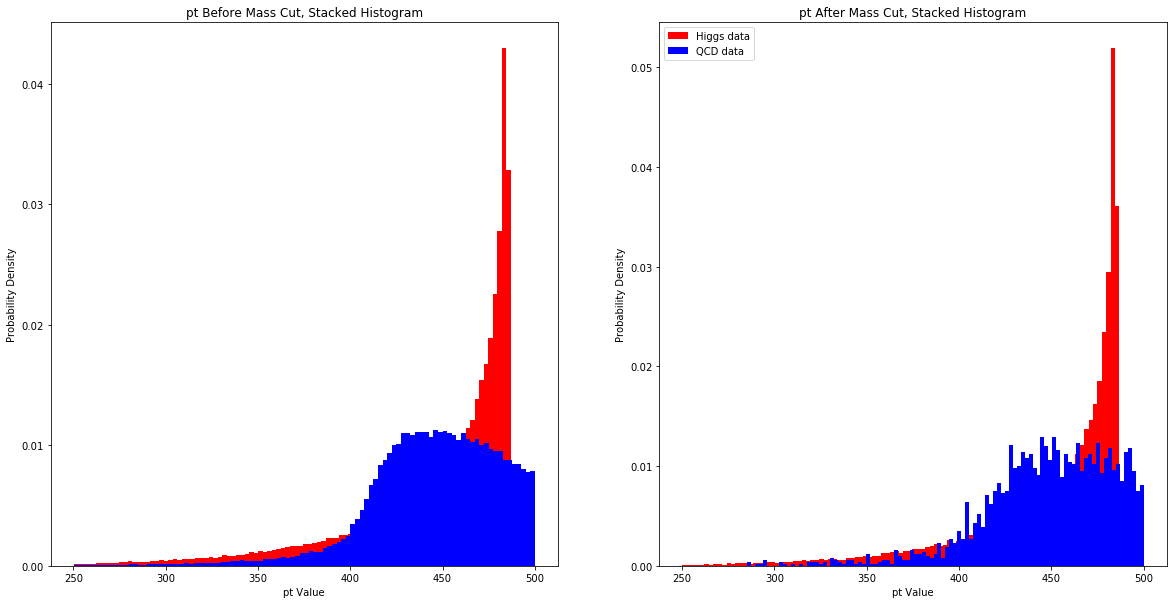

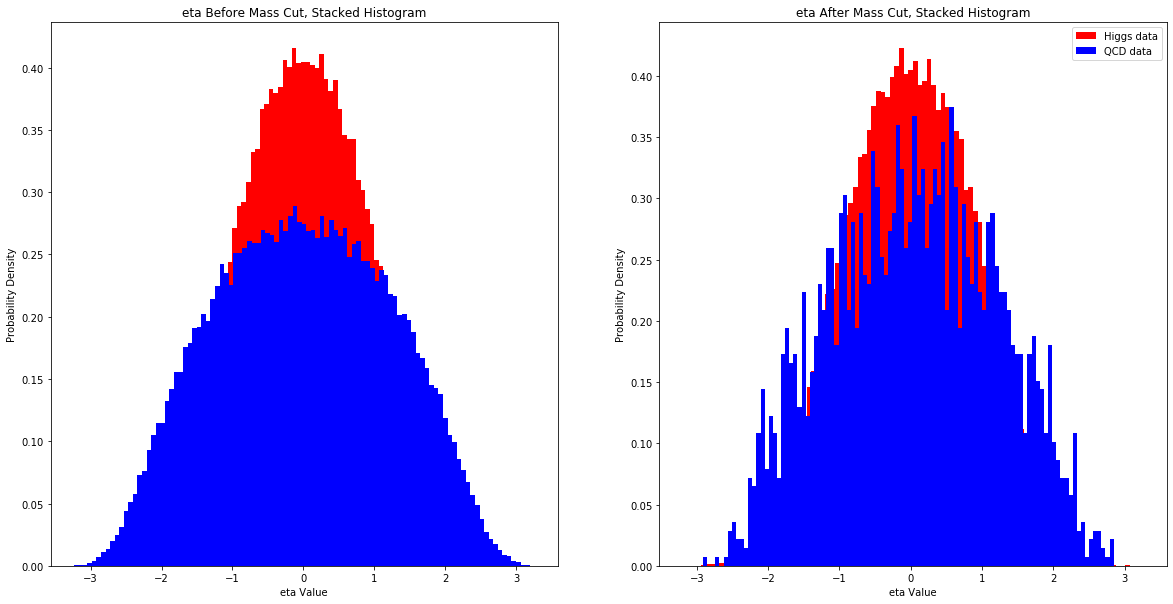

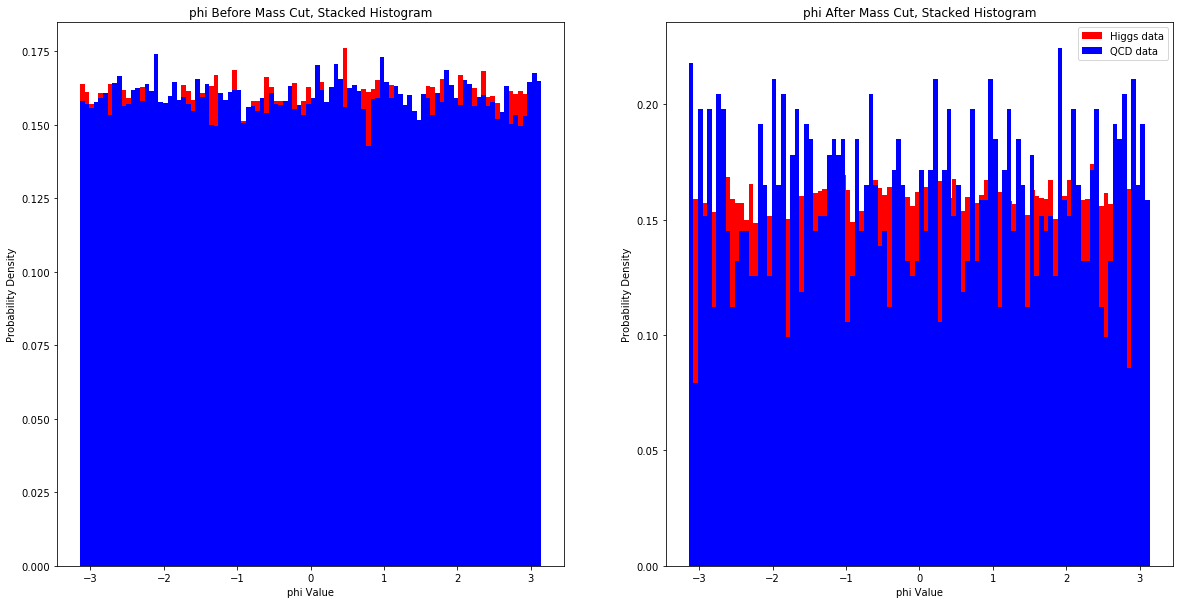

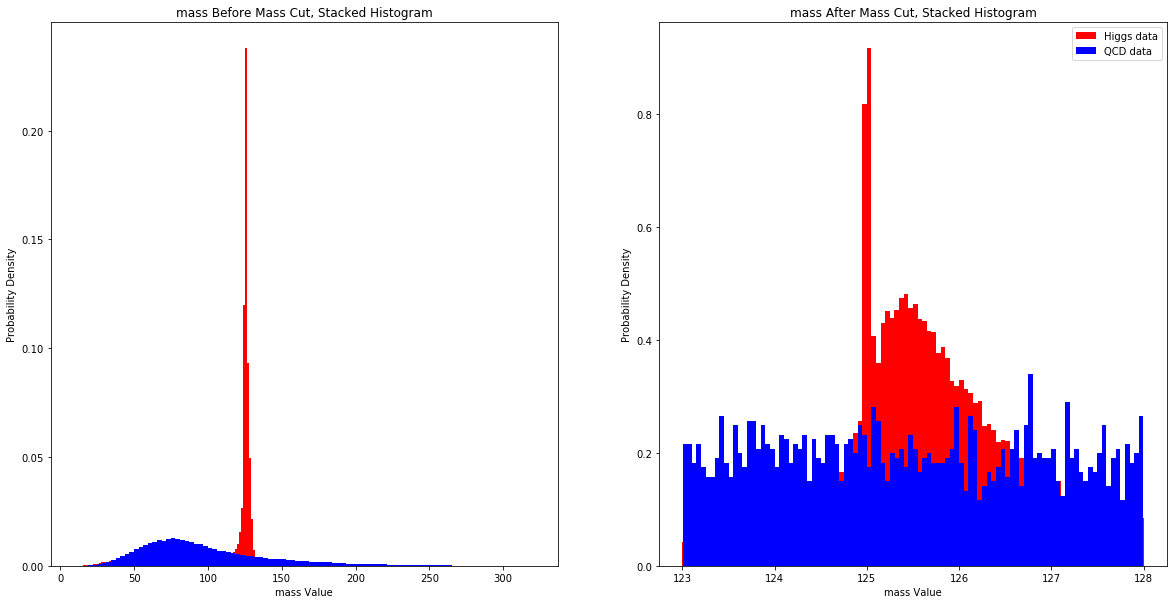

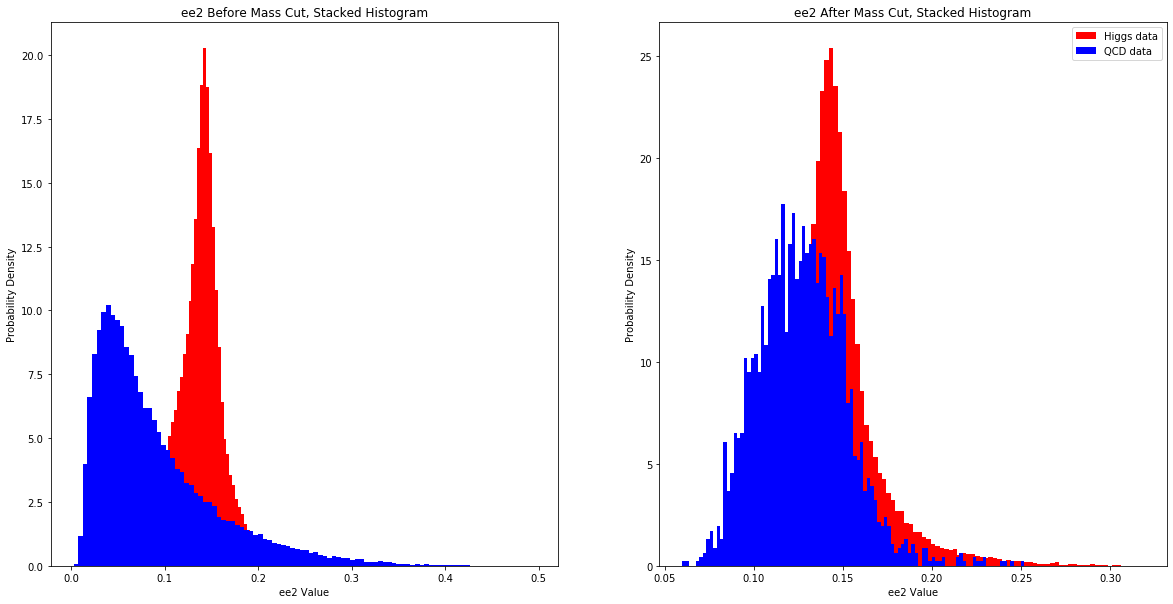

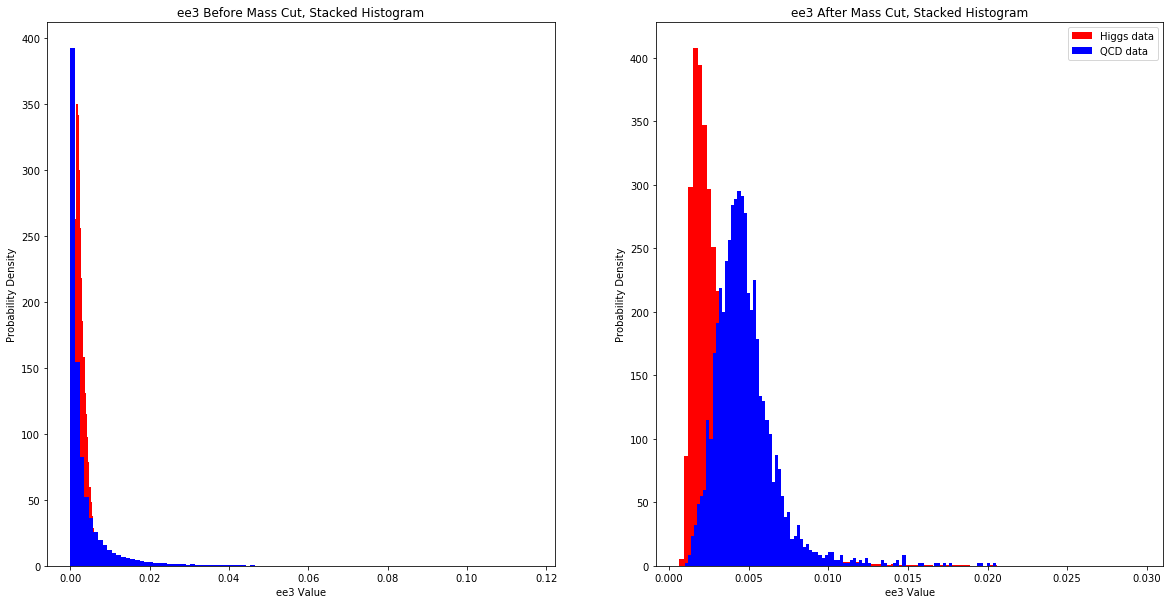

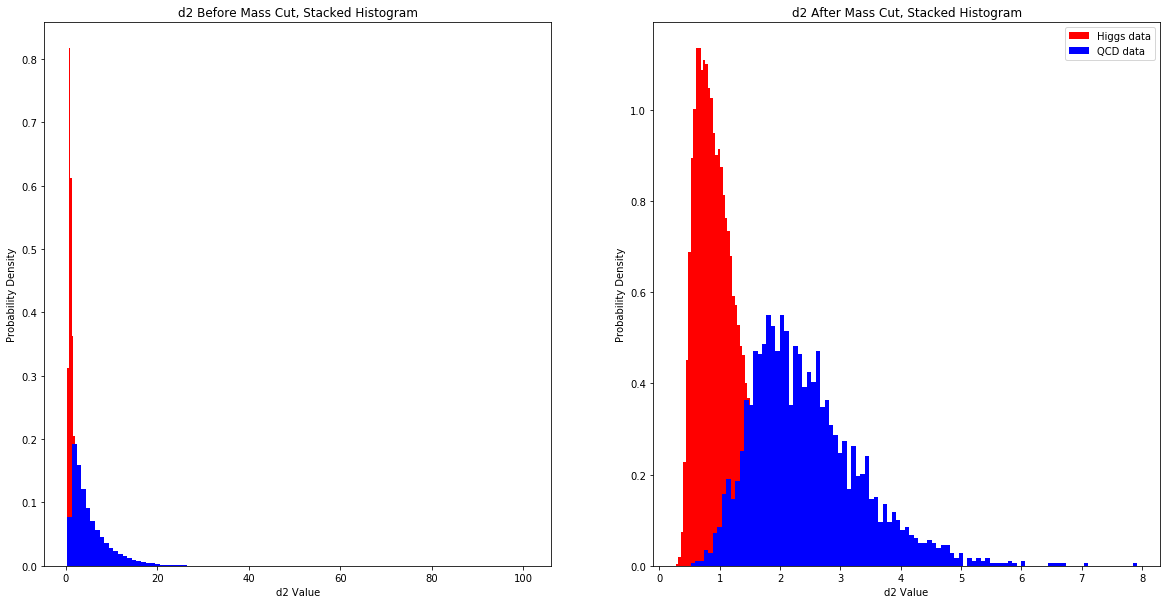

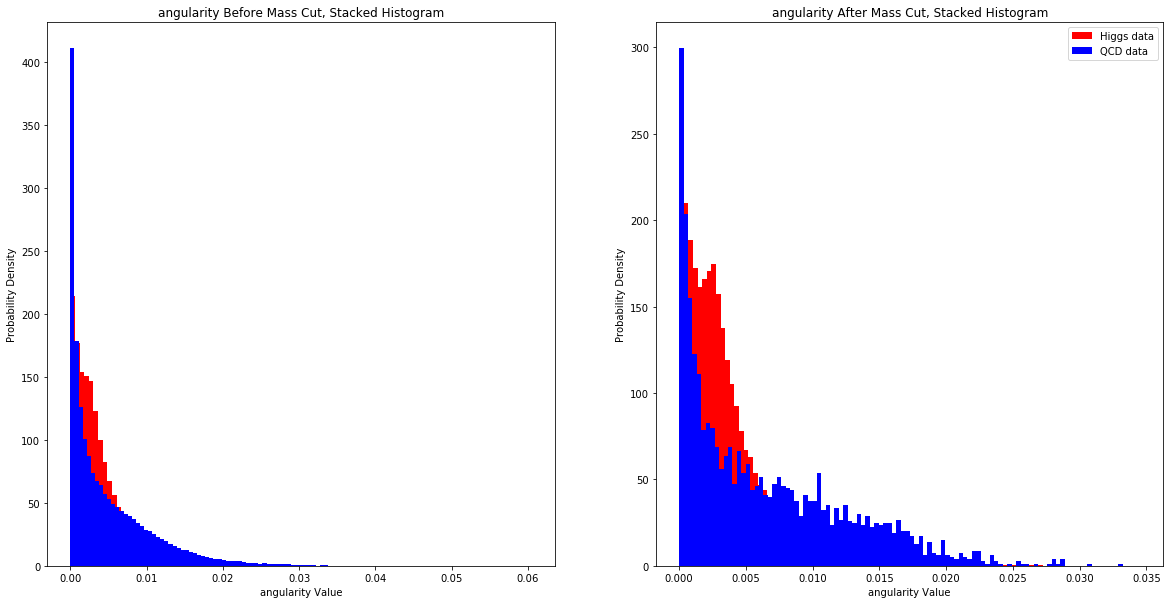

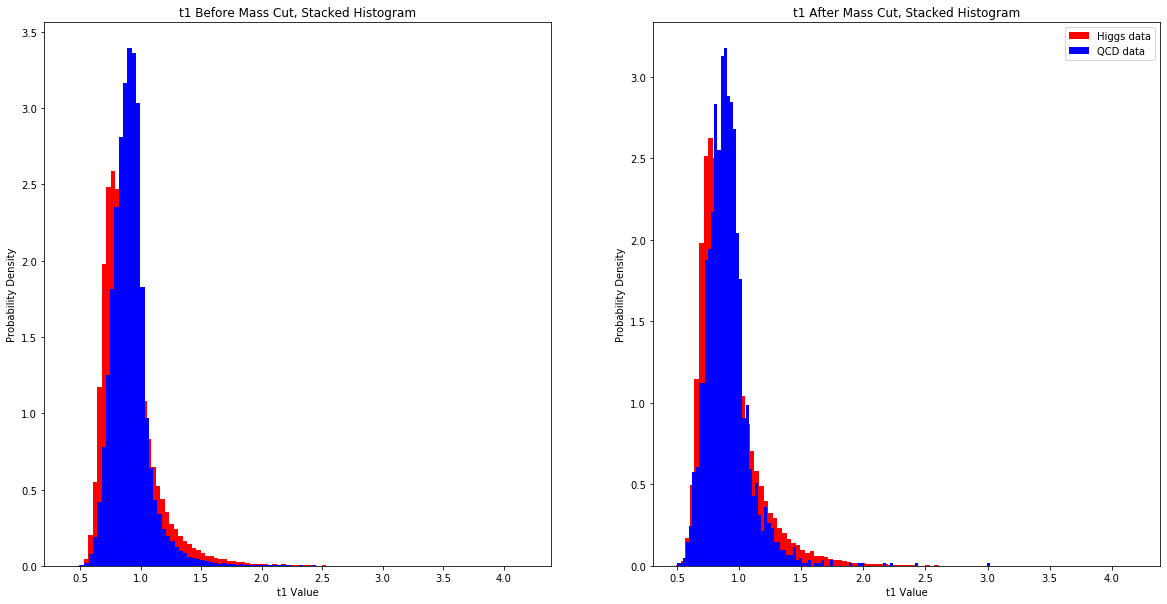

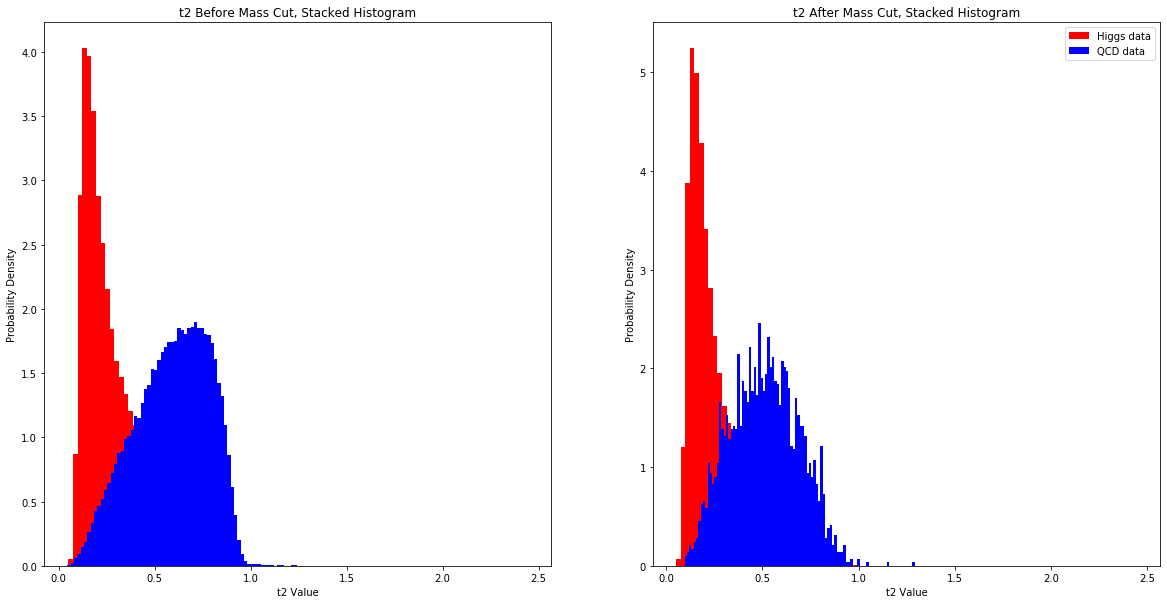

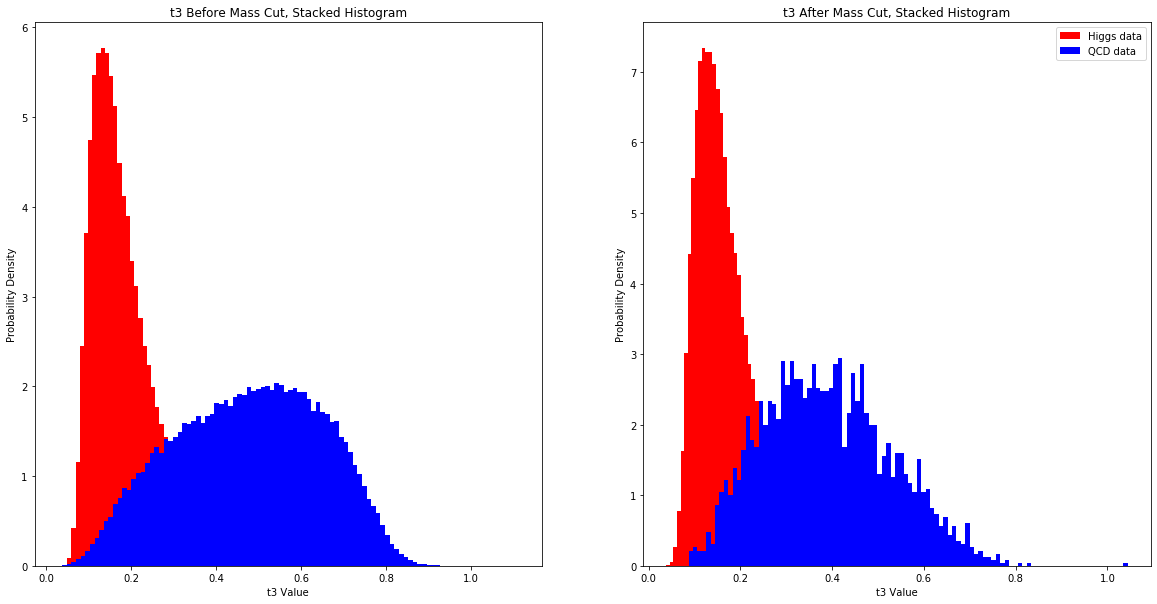

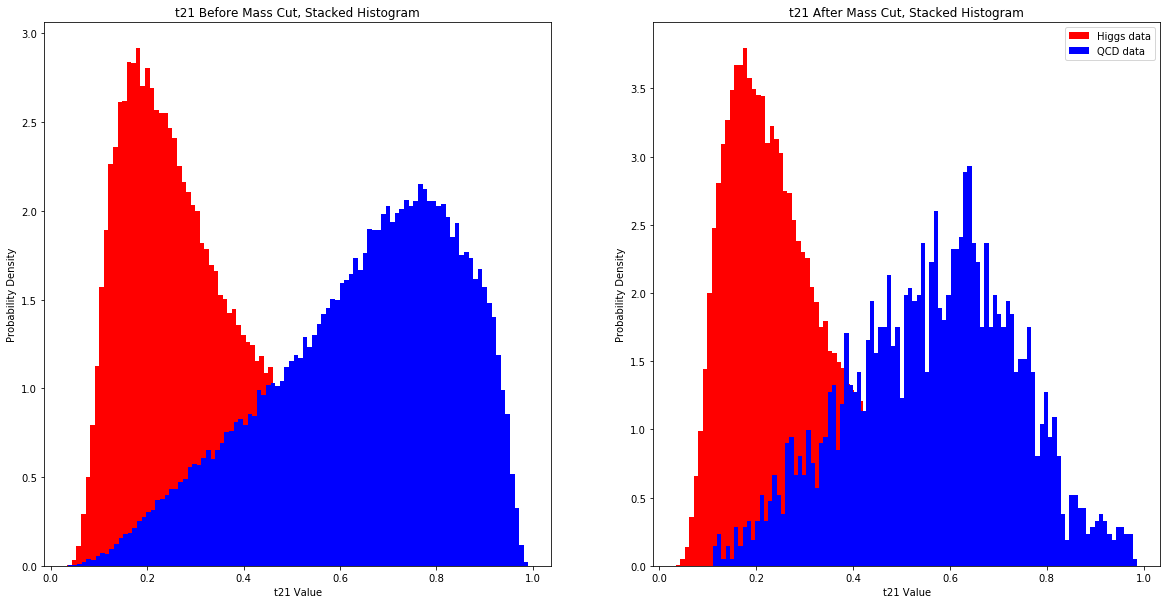

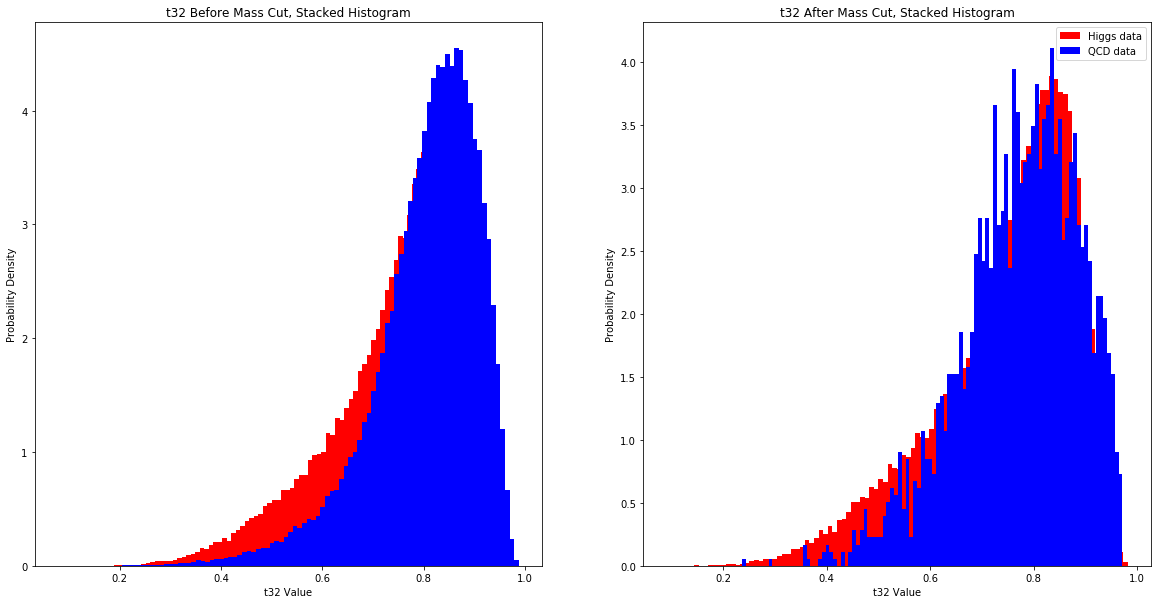

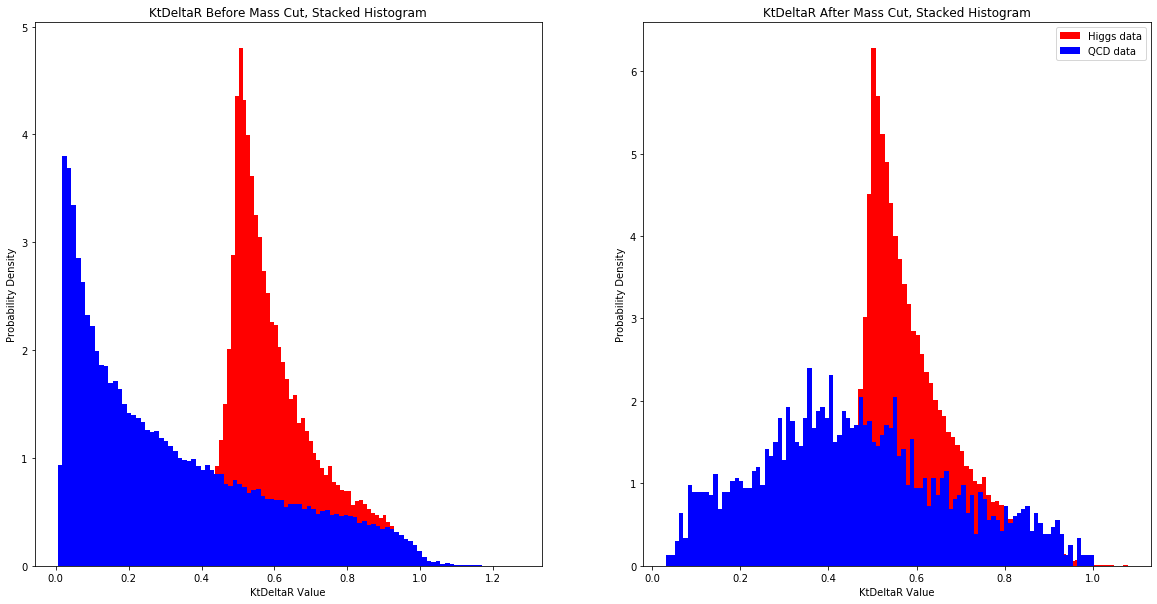

In [13]:
for key in higgs_data.keys():
    higgs_vals = higgs_data[key][mass_cut_higgs_indices]
    qcd_vals = qcd_data[key][mass_cut_qcd_indices]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hist(higgs_data[key], 100, density=True, color='r', label='Higgs data')
    ax1.hist(qcd_data[key], 100, density=True, color='b', label='QCD data')
    ax2.hist(higgs_vals, 100, density=True, color='r', label='Higgs data')
    ax2.hist(qcd_vals, 100, density=True, color='b', label='QCD data')
    ax1.set_title(str(key) + ' Before Mass Cut, Stacked Histogram')
    ax2.set_title(str(key) + ' After Mass Cut, Stacked Histogram')
    ax1.set_xlabel(str(key) + ' Value')
    ax2.set_xlabel(str(key) + ' Value')
    ax1.set_ylabel('Probability Density')
    ax2.set_ylabel('Probability Density')
    plt.legend()
    plt.show()

The features pt, d2, t3, t2, t21, and KtDeltaR look like they may provide similar discrimination to mass after the mass cut.

## Problem 4

Creating two function to find the optimal lower bound and upper bound for a general feature cut given a lower bound and upper bound as guesses:

In [15]:
def findLower(lower, upper):
    max_sig = 0
    max_lower = lower
    for i in np.arange(lower, upper, (upper - lower) / 20):
        higgs_count = makeCut(i, upper)[0]
        qcd_count = makeCut(i, upper)[1]
        sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
        if sig > max_sig and sig < 10000:
            max_sig = sig
            max_lower = i
    print(max_sig)
    print(max_lower)

In [16]:
def findUpper(lower, upper):
    max_sig = 0
    max_upper = upper
    for i in np.linspace(0.0, upper - lower, 20, endpoint=False):
        higgs_count = makeCut(lower, upper - i)[0]
        qcd_count = makeCut(lower, upper - i)[1]
        sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
        if sig > max_sig and sig < 10000:
            max_sig = sig
            max_upper = upper - i
    print(max_sig)
    print(max_upper)

Now, finding optimal cut after the mass cut for each of the variables identified as discriminatory:

Finding pt upper and lower bounds to maximize discovery significance:

In [17]:
higgs_temp = higgs_data['pt'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['pt'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [23]:
findLower(450, 500)

2.600753426317833
457.5


In [24]:
findUpper(457.5, 500)

2.965624088208362
487.25


So optimal pt cut is from 457.5 to 487.25 with significance of 2.966$\sigma$.

In [18]:
higgs_temp = higgs_data['d2'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['d2'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [26]:
findLower(0.0, 2.0)

4.406211934822533
0.0


In [27]:
findUpper(0.0, 2.0)

7.928367942870712
0.7


So the optimal d2 cut is from 0.0 to 0.7 with significance of 7.923$\sigma$.

Finding t3 upper and lower bounds to maximize discovery significance:

In [12]:
higgs_temp = higgs_data['t3'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['t3'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [29]:
findLower(0.0, 1.0)

2.87390168626212
0.0


In [30]:
findUpper(0.0, 1.0)

7.162143256491439
0.1499999999999999


So optimal t3 cut is from 0.0 to 0.15 with significance of 7.162$\sigma$.

Finding t2 upper and lower bounds to maximize discovery significance:

In [31]:
higgs_temp = higgs_data['t2'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['t2'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [32]:
findLower(0.0, 1.0)

2.858139403923798
0.0


In [33]:
findUpper(0.0, 1.0)

6.404059407884905
0.19999999999999996


So optimal t2 cut is from 0.0 to 0.2 with significance of 6.404$\sigma$.

Finding t21 upper and lower bounds to maximize discovery significance:

In [34]:
higgs_temp = higgs_data['t21'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['t21'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [35]:
findLower(0.0, 0.6)

3.6864857581012083
0.0


In [36]:
findUpper(0.0, 0.6)

6.193815217225589
0.24


So optimal t21 cut is from 0.0 to 0.24 with significance of 6.194$\sigma$.

In [37]:
higgs_temp = higgs_data['KtDeltaR'][mass_cut_higgs_indices].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['KtDeltaR'][mass_cut_qcd_indices].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [38]:
findLower(0.2, 0.8)

3.82524762183328
0.47000000000000003


In [39]:
findUpper(0.47, 0.8)

3.846429270855041
0.7505000000000001


So optimal KtDelta R cut is from 0.47 to 0.75 with significance of 3.846$\sigma$.

After testing multiple other feature cuts combined with the mass cut, the d2 feature provides the highest discrimination. When combining the mass cut of [123, 128] with the d2 cut of [0.0, 0.7], we get a discovery significance of 7.928$\sigma$.

# Lab #8

In [19]:
high_lumi_data = pd.read_hdf('data_highLumi_pt_250_500.h5')
low_lumi_data = pd.read_hdf('data_lowLumi_pt_250_500.h5')

## Problem 1

In [20]:
high_lumi_masses = np.array(high_lumi_data.get('mass'))
low_lumi_masses = np.array(low_lumi_data.get('mass'))

In [21]:
higgs_temp = higgs_data['mass'].values
higgs_events = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['mass'].values
qcd_events = qcd_temp[0:len(qcd_temp)]

In [22]:
temp = makeCut(123, 128)
mass_cut_higgs_indices = temp[2]
mass_cut_qcd_indices = temp[3]
higgs_cut_masses = higgs_data['mass'][mass_cut_higgs_indices]
qcd_cut_masses = qcd_data['mass'][mass_cut_qcd_indices]

Creating a function to cut the pseudo-experiment data given an upper and lower bound and the data feature as an array:

In [23]:
def lumiCut(lower, upper, vals):
    cut_indices = []
    for i in range(0, len(vals)):
        if vals[i] >= lower and vals[i] <= upper:
            cut_indices.append(i)
    return cut_indices

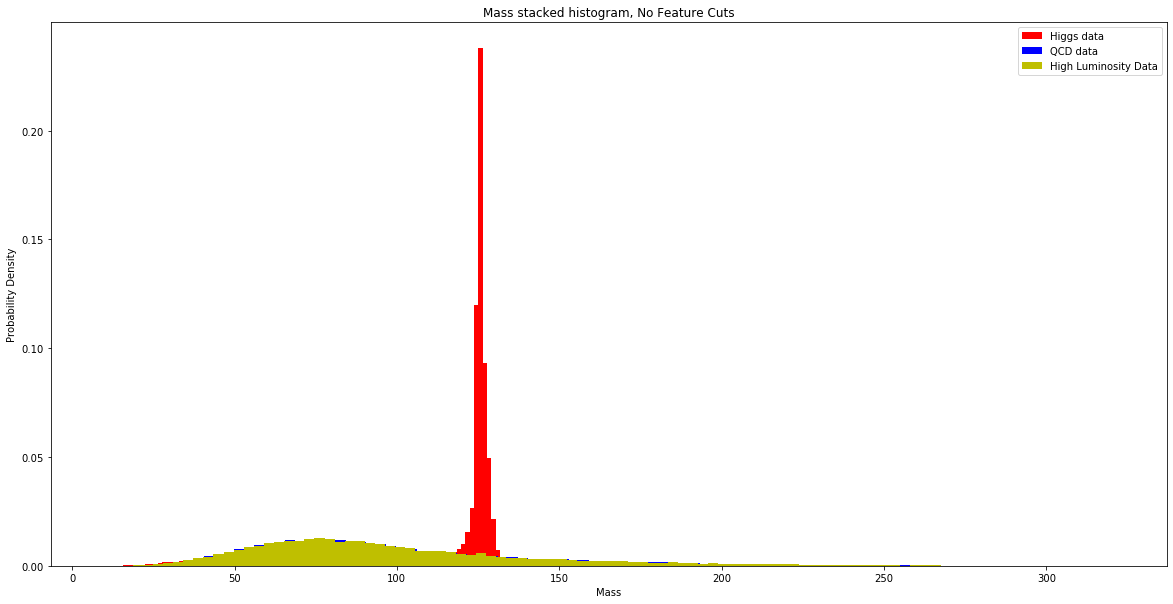

In [19]:
plt.hist(higgs_data['mass'], 100, density=True, color='r', label='Higgs data')
plt.hist(qcd_data['mass'], 100, density=True, color='b', label='QCD data')
plt.hist(high_lumi_masses, 100, density=True, color='y', label='High Luminosity Data')
plt.title('Mass stacked histogram, No Feature Cuts')
plt.xlabel('Mass')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [24]:
mass_cut_high_indices = lumiCut(123, 128, high_lumi_masses)

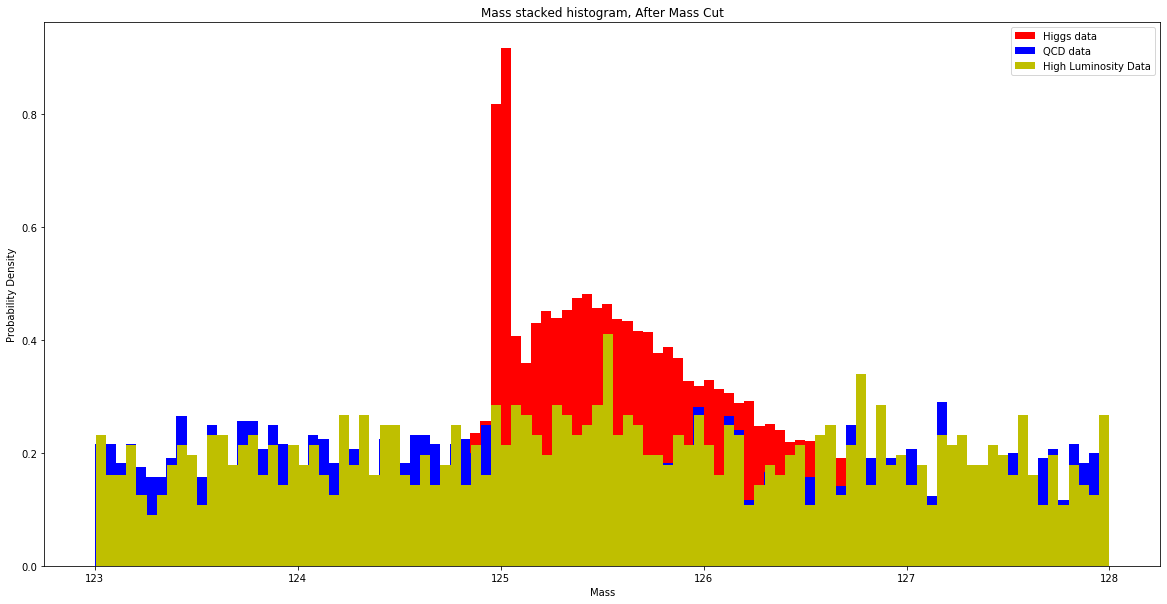

In [21]:
plt.hist(higgs_cut_masses, 100, density=True, color='r', label='Higgs data')
plt.hist(qcd_cut_masses, 100, density=True, color='b', label='QCD data')
plt.hist(high_lumi_masses[mass_cut_high_indices], 100, density=True, color='y', label='High Luminosity Data')
plt.title('Mass stacked histogram, After Mass Cut')
plt.xlabel('Mass')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [25]:
high_lumi_d2 = np.array(high_lumi_data.get('d2'))

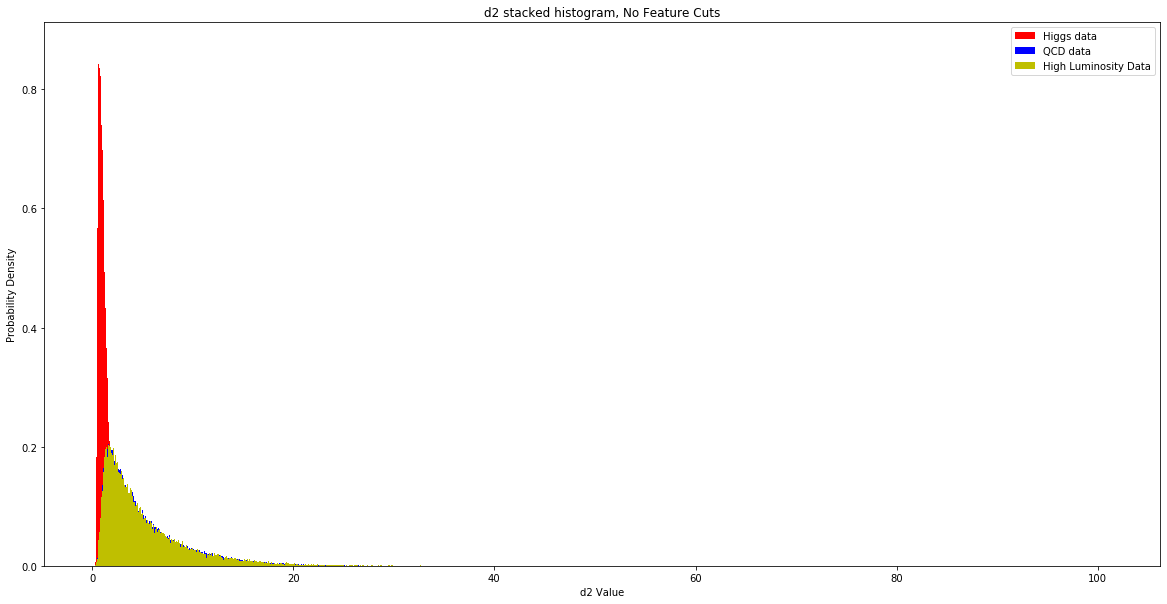

In [45]:
plt.hist(higgs_data['d2'], 1000, density=True, color='r', label='Higgs data')
plt.hist(qcd_data['d2'], 1000, density=True, color='b', label='QCD data')
plt.hist(high_lumi_d2, 1000, density=True, color='y', label='High Luminosity Data')
plt.title('d2 stacked histogram, No Feature Cuts')
plt.xlabel('d2 Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Now, cutting the high luminosity data with the optimal d2 cut as well as the optimal mass cut:

In [26]:
higgs_events = higgs_data['d2'][mass_cut_higgs_indices].values
qcd_events = qcd_data['d2'][mass_cut_qcd_indices].values

In [27]:
temp = makeCut(0.0, 0.7)
d2_cut_higgs_indices = temp[2]
d2_cut_qcd_indices = temp[3]

In [28]:
d2_cut_higgs_d2 = higgs_events[d2_cut_higgs_indices]
d2_cut_qcd_d2 = qcd_events[d2_cut_qcd_indices]

In [29]:
mass_cut_high_lumi_d2 = high_lumi_d2[mass_cut_high_indices]

In [30]:
d2_cut_high_indices = lumiCut(0.0, 0.7, mass_cut_high_lumi_d2)

In [31]:
d2_cut_high = mass_cut_high_lumi_d2[d2_cut_high_indices]

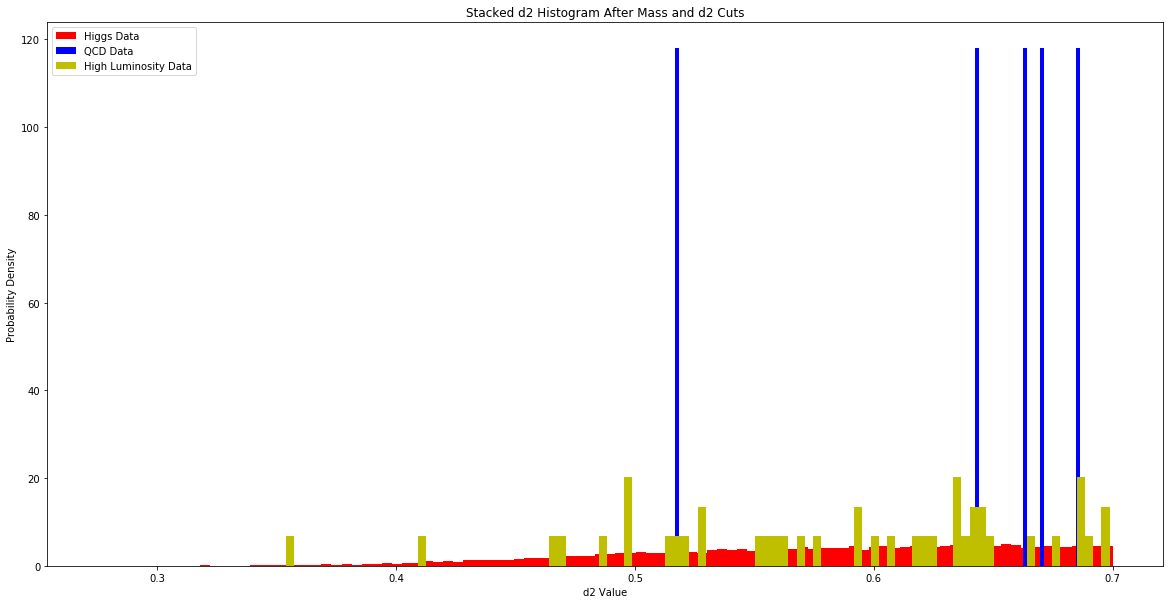

In [68]:
plt.hist(higgs_events[d2_cut_higgs_indices], 100, density=True, color='r', label='Higgs Data')
plt.hist(qcd_events[d2_cut_qcd_indices], 100, density=True, color='b', label='QCD Data')
plt.hist(d2_cut_high, 100, density=True, color='y', label='High Luminosity Data')
plt.xlabel('d2 Value')
plt.ylabel('Probability Density')
plt.title('Stacked d2 Histogram After Mass and d2 Cuts')
plt.legend()
plt.show()

Calculating the significance of the observed high luminosity data:

In [71]:
total_count = len(d2_cut_qcd_indices) + len(d2_cut_high)
sig = stats.norm.ppf(stats.poisson.cdf(total_count, len(d2_cut_qcd_indices)))
print('Significance = ' + str(sig))

Significance = inf


The expected significance after the mass and d2 cuts is 7.923$\sigma$, and the high luminosity data has a significance of $\infty$$\sigma$ after the mass and d2 cuts, which is more than enough to claim a discovery.

## Problem 2

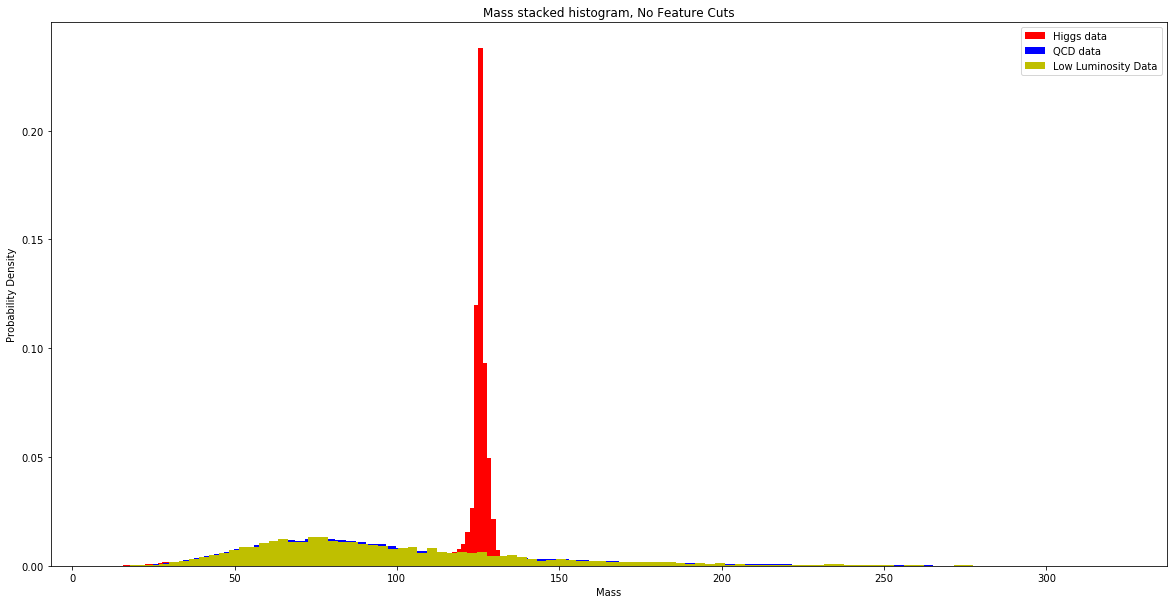

In [143]:
plt.hist(higgs_data['mass'], 100, density=True, color='r', label='Higgs data')
plt.hist(qcd_data['mass'], 100, density=True, color='b', label='QCD data')
plt.hist(low_lumi_masses, 100, density=True, color='y', label='Low Luminosity Data')
plt.title('Mass stacked histogram, No Feature Cuts')
plt.xlabel('Mass')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [37]:
mass_cut_low_indices = lumiCut(123, 128, low_lumi_masses)

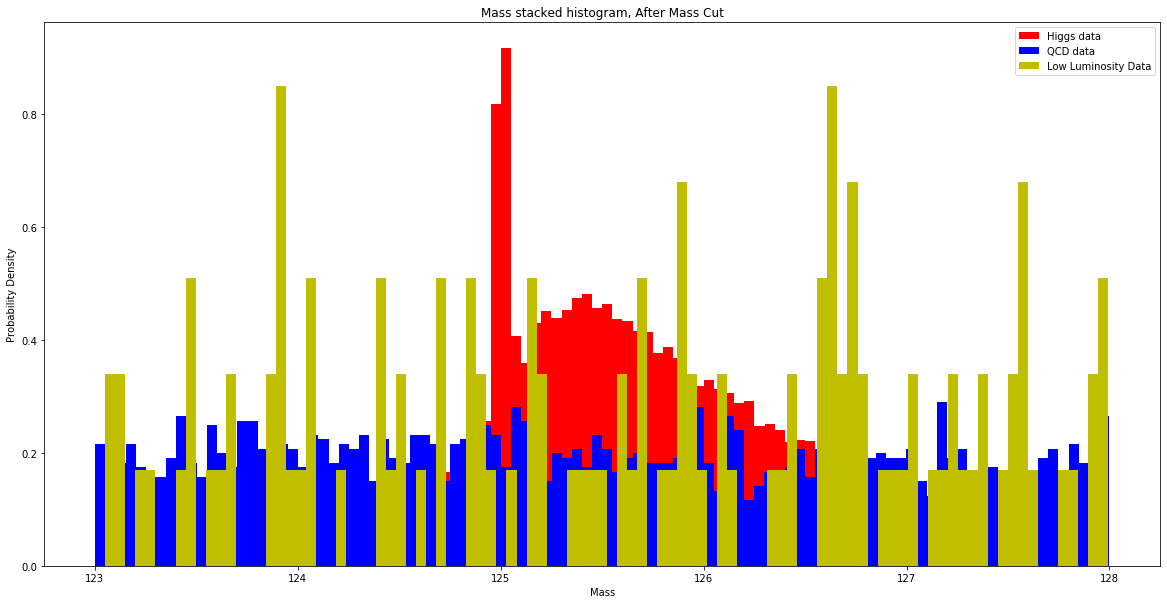

In [66]:
plt.hist(higgs_cut_masses, 100, density=True, color='r', label='Higgs data')
plt.hist(qcd_cut_masses, 100, density=True, color='b', label='QCD data')
plt.hist(low_lumi_masses[mass_cut_low_indices], 100, density=True, color='y', label='Low Luminosity Data')
plt.title('Mass stacked histogram, After Mass Cut')
plt.xlabel('Mass')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [75]:
low_lumi_d2 = np.array(low_lumi_data.get('d2'))

In [42]:
low_lumi_d2 = np.array(low_lumi_data.get('d2'))

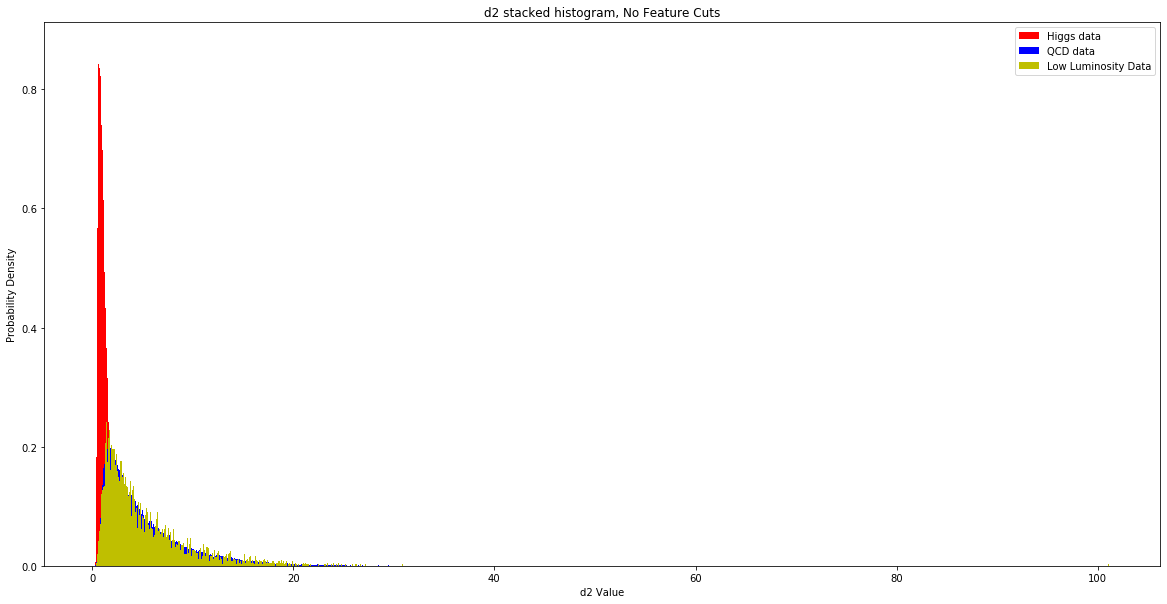

In [46]:
plt.hist(higgs_data['d2'], 1000, density=True, color='r', label='Higgs data')
plt.hist(qcd_data['d2'], 1000, density=True, color='b', label='QCD data')
plt.hist(low_lumi_d2, 1000, density=True, color='y', label='Low Luminosity Data')
plt.title('d2 stacked histogram, No Feature Cuts')
plt.xlabel('d2 Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [49]:
mass_cut_low_lumi_d2 = low_lumi_d2[mass_cut_low_indices]

In [50]:
d2_cut_low_indices = lumiCut(0.0, 0.7, mass_cut_low_lumi_d2)

In [53]:
d2_cut_low = mass_cut_low_lumi_d2[d2_cut_low_indices]

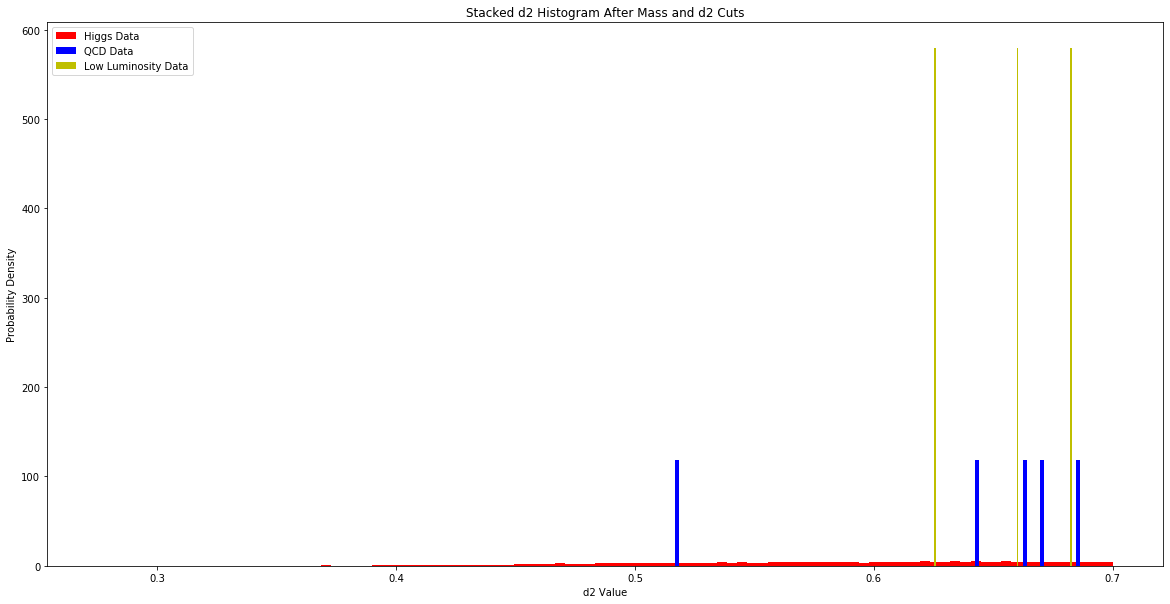

In [74]:
plt.hist(higgs_events[d2_cut_higgs_indices], 100, density=True, color='r', label='Higgs Data')
plt.hist(qcd_events[d2_cut_qcd_indices], 100, density=True, color='b', label='QCD Data')
plt.hist(d2_cut_low, 100, density=True, color='y', label='Low Luminosity Data')
plt.xlabel('d2 Value')
plt.ylabel('Probability Density')
plt.title('Stacked d2 Histogram After Mass and d2 Cuts')
plt.legend()
plt.show()

In [85]:
total_count = len(d2_cut_qcd_indices) + len(d2_cut_low)
sig = stats.norm.ppf(stats.poisson.cdf(total_count, len(d2_cut_qcd_indices)))
print('Significance = ' + str(sig))

Significance = 1.4901406054758806


The expected significance after the mass and d2 cuts is 7.923$\sigma$, and the low luminosity data has a significance of 1.4901$\sigma$ after the mass and d2 cuts, which is not high enough to claim a discovery.